In [1]:
!pip install simpletransformers==0.65.1

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import files
uploades = files.upload()

Saving combined.csv to combined.csv


In [3]:
#trained = pd.read_csv('C:/Users/feter/OneDrive/Bureaublad/AI/AI Year 3/p4/text mining/train_files/combined.csv',delimiter=';')
trained = pd.read_csv('/content/combined.csv',delimiter=';')

In [4]:
# Define label mapping dictionary
label_mapping = {
    'Movie': 0,
    'Book': 1,
    'Sports': 2
}

# Map original labels to new label indices
# trained = trained['Topic'].map(label_mapping)
trained['Topic'] = trained['Topic'].replace('Movie', 0)
trained['Topic'] = trained['Topic'].replace('Book', 1)
trained['Topic'] = trained['Topic'].replace('Sports', 2)

# Display unique values in the new column
trained[:1000]

,review,Topic
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0
...,...,...
995,Nothing is sacred. Just ask Ernie Fosselius. T...,0
996,I hated it. I hate self-aware pretentious inan...,0
997,I usually try to be professional and construct...,0
998,If you like me is going to see this in a film ...,0


In [5]:
train = pd.DataFrame({'text': trained.review, 'labels': trained.Topic})

In [6]:
print(len(train))
train.head(5)

2997


,text,labels
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [7]:
path  = pd.read_csv('/content/sentiment-topic-test.tsv', sep='\t')

In [8]:
path['topic'] = path['topic'].replace('movie', 0)
path['topic'] = path['topic'].replace('book', 1)
path['topic'] = path['topic'].replace('sports', 2)

path[:1000]

,sentence id,text,sentiment,topic
0,0,I wouldn't be caught dead watching the NFL if ...,negative,2
1,1,Chris O'Donnell stated that while filming for ...,neutral,0
2,2,"The whole game was a rollercoaster ride, but L...",positive,2
3,3,"Zendaya slayed in Dune 2, as she does in all h...",positive,0
4,4,While my favorite player was playing this matc...,negative,2
5,5,My uncle's brother's neighbor's cat's veterina...,neutral,1
6,6,He said that The Great Gatsby is the best nove...,negative,1
7,7,I could not look away from this train wrck of ...,negative,0
8,8,The film Everything Everywhere All At Once fol...,neutral,0
9,9,I just finished reading pride and prejudice wh...,positive,1


In [9]:
test = pd.DataFrame({'text': path.text, 'labels': path.topic})

In [10]:
print(len(test))
test.head(5)

10


,text,labels
0,I wouldn't be caught dead watching the NFL if ...,2
1,Chris O'Donnell stated that while filming for ...,0
2,"The whole game was a rollercoaster ride, but L...",2
3,"Zendaya slayed in Dune 2, as she does in all h...",0
4,While my favorite player was playing this matc...,2


In [11]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=42,
                               stratify=train[['labels']])

In [21]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.001 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=5
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [22]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 85 steps.


In [23]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.001
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=5
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_se

In [25]:
_, history = model.train_model(train, eval_df=dev)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

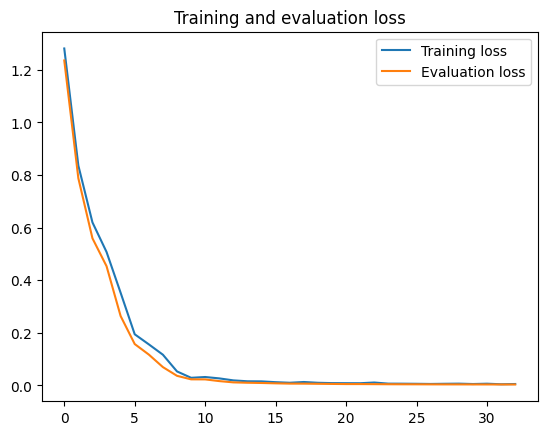

In [26]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [27]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

{'mcc': 1.0, 'eval_loss': 0.0035220718321700892}

In [28]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.30      1.00      0.46         3
           2       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.10      0.33      0.15        10
weighted avg       0.09      0.30      0.14        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
